<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [22]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizo El Libro "Probabilidad y Estadistica para Ingenieria y Ciencias - Jay Devore - Septima Edicion" de Jay Devore

In [23]:
# Si no está instalada, hace falta instalar este modulo para leer PDFs
# pip install PyPDF2

In [24]:
# importing all the required modules
import PyPDF2

# creating a pdf reader object
reader1 = PyPDF2.PdfReader('Probabilidad y Estadistica para Ingenieria y Ciencias - Jay Devore - Septima Edicion.pdf')


texto = ""
for p in reader1.pages:
    texto+=p.extract_text()


len(texto)

2560907

In [25]:
import re
import unicodedata
import string

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [26]:
texto2 = preprocess_clean_text(texto).split('\n')

In [27]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.DataFrame(texto2, columns=['doc'])
df = df[df['doc']!=' ']
# Tomo una parte para que no sea tan pesado
df = df[10000:20000]

df[:100]

,doc
10020,fxHH
10021,cH HcHxHHHc
10022,de lo contrarioHHHHHHHHEjemplo cpqxd AM ...
10023,bucion de Cauchy y es una distribucion unifo...
10024,colas muchos mas gruesas mas probabilidad haci...
...,...
10115,HHel sobre H recalca que HHesta siendo estima...
10116,Ejemplo
10117,continuacion
10118,del ejemplocpqxd AM Page HHHHHHHHHHHHHHH ...


In [28]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 10000


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [29]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [30]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.iloc[2,0]
text

' de lo contrarioHHHHHHHHEjemplo cpqxd     AM  Page La funcion de densidad de probabilidad  es la distribucion normal  se llama distri'

In [31]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['de',
 'lo',
 'contrariohhhhhhhhejemplo',
 'cpqxd',
 'am',
 'page',
 'la',
 'funcion',
 'de',
 'densidad',
 'de',
 'probabilidad',
 'es',
 'la',
 'distribucion',
 'normal',
 'se',
 'llama',
 'distri']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [32]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [33]:
# Demos un vistazo
sentence_tokens[:2]

[['fxhh'], ['ch', 'hchxhhhc']]

In [34]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)+1):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [35]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['de', 'lo', 'contrariohhhhhhhhejemplo', 'cpqxd'],
 ['lo', 'contrariohhhhhhhhejemplo', 'cpqxd', 'am'],
 ['contrariohhhhhhhhejemplo', 'cpqxd', 'am', 'page'],
 ['cpqxd', 'am', 'page', 'la'],
 ['am', 'page', 'la', 'funcion'],
 ['page', 'la', 'funcion', 'de'],
 ['la', 'funcion', 'de', 'densidad'],
 ['funcion', 'de', 'densidad', 'de'],
 ['de', 'densidad', 'de', 'probabilidad'],
 ['densidad', 'de', 'probabilidad', 'es'],
 ['de', 'probabilidad', 'es', 'la'],
 ['probabilidad', 'es', 'la', 'distribucion'],
 ['es', 'la', 'distribucion', 'normal'],
 ['la', 'distribucion', 'normal', 'se'],
 ['distribucion', 'normal', 'se', 'llama'],
 ['normal', 'se', 'llama', 'distri']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [36]:
tok = Tokenizer() 

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [37]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[1, 14, 12, 3],
 [14, 12, 3, 4],
 [12, 3, 4, 5],
 [3, 4, 5, 2],
 [4, 5, 2, 6],
 [5, 2, 6, 1],
 [2, 6, 1, 7],
 [6, 1, 7, 1],
 [1, 7, 1, 8],
 [7, 1, 8, 9],
 [1, 8, 9, 2],
 [8, 9, 2, 10],
 [9, 2, 10, 11],
 [2, 10, 11, 13],
 [10, 11, 13, 15],
 [11, 13, 15, 16]]

In [38]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

16


In [39]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

16


In [40]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'la': 2, 'cpqxd': 3, 'am': 4, 'page': 5, 'funcion': 6, 'densidad': 7, 'probabilidad': 8, 'es': 9, 'distribucion': 10, 'normal': 11, 'contrariohhhhhhhhejemplo': 12, 'se': 13, 'lo': 14, 'llama': 15, 'distri': 16}


In [41]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'contrariohhhhhhhhejemplo': 3, 'lo': 2, 'cpqxd': 4, 'de': 7, 'am': 4, 'page': 4, 'la': 8, 'funcion': 4, 'densidad': 4, 'probabilidad': 4, 'es': 4, 'distribucion': 4, 'normal': 4, 'se': 3, 'llama': 2, 'distri': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [43]:
# Vistazo a las primeras filas
df.iloc[:15,0]

10020                                                 fxHH
10021                                          cH HcHxHHHc
10022     de lo contrarioHHHHHHHHEjemplo cpqxd     AM  ...
10023    bucion de Cauchy y  es una  distribucion unifo...
10024    colas muchos mas gruesas mas probabilidad haci...
10025                                                    X
10026    H  XHeel promedio de las dos observaciones ext...
10027    La muy importante moraleja en este caso es que...
10028    cialmente de que distribucion esta siendo mues...
10029    Si la muestra aleatoria proviene de una distri...
10030    de los cuatro estimadores puesto que tiene una...
10031                                    dores insesgados 
10032    Si la muestra aleatoria proviene de una distri...
10033    madores terribles de H en tanto que es bastant...
10034     Hes malo porque es muy sensible a las observacio
Name: doc, dtype: object

In [44]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)['doc']
corpus

'fxHH cH HcHxHHHc  de lo contrarioHHHHHHHHEjemplo cpqxd     AM  Page La funcion de densidad de probabilidad  es la distribucion normal  se llama distri bucion de Cauchy y  es una  distribucion uniforme Las tres distribuciones son simetricascon respecto a H y de hecho la distribucion de Cauchy tiene forma de campana pero con colas muchos mas gruesas mas probabilidad hacia fuera que la curva normal La distribucion uniforme no tiene colas Los cuatro estimadores de H considerados con anterioridad son X H  XHeel promedio de las dos observaciones extremas y XHrec  una media recortada  La muy importante moraleja en este caso es que el mejor estimador de H depende cru cialmente de que distribucion esta siendo muestreada En particular  Si la muestra aleatoria proviene de una distribucion  normal en ese caso XHes el mejor de los cuatro estimadores puesto que tiene una varianza minima entre todos los estima dores insesgados  Si la muestra aleatoria proviene de una distribucion de Cauchy entonces 

In [45]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['fxhh',
 'ch',
 'hchxhhhc',
 'de',
 'lo',
 'contrariohhhhhhhhejemplo',
 'cpqxd',
 'am',
 'page',
 'la',
 'funcion',
 'de',
 'densidad',
 'de',
 'probabilidad',
 'es',
 'la',
 'distribucion',
 'normal',
 'se']

In [46]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 110380


In [47]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)+1):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [48]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['fxhh', 'ch', 'hchxhhhc', 'de'],
 ['ch', 'hchxhhhc', 'de', 'lo'],
 ['hchxhhhc', 'de', 'lo', 'contrariohhhhhhhhejemplo'],
 ['de', 'lo', 'contrariohhhhhhhhejemplo', 'cpqxd'],
 ['lo', 'contrariohhhhhhhhejemplo', 'cpqxd', 'am'],
 ['contrariohhhhhhhhejemplo', 'cpqxd', 'am', 'page'],
 ['cpqxd', 'am', 'page', 'la'],
 ['am', 'page', 'la', 'funcion'],
 ['page', 'la', 'funcion', 'de'],
 ['la', 'funcion', 'de', 'densidad'],
 ['funcion', 'de', 'densidad', 'de'],
 ['de', 'densidad', 'de', 'probabilidad'],
 ['densidad', 'de', 'probabilidad', 'es'],
 ['de', 'probabilidad', 'es', 'la'],
 ['probabilidad', 'es', 'la', 'distribucion'],
 ['es', 'la', 'distribucion', 'normal'],
 ['la', 'distribucion', 'normal', 'se'],
 ['distribucion', 'normal', 'se', 'llama'],
 ['normal', 'se', 'llama', 'distri'],
 ['se', 'llama', 'distri', 'bucion']]

In [49]:
# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[4946, 994, 12453, 1],
 [994, 12453, 1, 55],
 [12453, 1, 55, 4947],
 [1, 55, 4947, 143],
 [55, 4947, 143, 51],
 [4947, 143, 51, 53],
 [143, 51, 53, 2],
 [51, 53, 2, 135],
 [53, 2, 135, 1],
 [2, 135, 1, 253],
 [135, 1, 253, 1],
 [1, 253, 1, 56],
 [253, 1, 56, 14],
 [1, 56, 14, 2],
 [56, 14, 2, 35],
 [14, 2, 35, 52],
 [2, 35, 52, 8],
 [35, 52, 8, 458],
 [52, 8, 458, 867],
 [8, 458, 867, 1203]]

In [50]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 110377


### 3 - Input y target

In [51]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(110377, 3)
(110377,)


In [52]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'el',
 4: 'h',
 5: 'que',
 6: 'en',
 7: 'y',
 8: 'se',
 9: 'una',
 10: 'un',
 11: 'a',
 12: 'con',
 13: 'los',
 14: 'es',
 15: 'para',
 16: 'las',
 17: 'del',
 18: 'por',
 19: 'hh',
 20: 'valor',
 21: 'prueba',
 22: 'muestra',
 23: 'si',
 24: 'dos',
 25: 'nivel',
 26: 'no',
 27: 'como',
 28: 'cuando',
 29: 'datos',
 30: 'x',
 31: 'confianza',
 32: 'intervalo',
 33: 'mas',
 34: 'al',
 35: 'distribucion',
 36: 'cada',
 37: 'ser',
 38: 'son',
 39: 'hipotesis',
 40: 'promedio',
 41: 'ejemplo',
 42: 'p',
 43: 'esta',
 44: 'o',
 45: 'entre',
 46: 'poblacion',
 47: 'valores',
 48: 'media',
 49: 'estandar',
 50: 'verdadera',
 51: 'am',
 52: 'normal',
 53: 'page',
 54: 'tipo',
 55: 'lo',
 56: 'probabilidad',
 57: 'of',
 58: 'sobre',
 59: 'cual',
 60: 'b',
 61: 'hhh',
 62: 'i',
 63: 'este',
 64: 'puede',
 65: 'ha',
 66: 'tabla',
 67: 'n',
 68: 'j',
 69: 'error',
 70: 'factor',
 71: 'entonces',
 72: 'sea',
 73: 'grande',
 74: 'capitulo',
 75: 'diferentes',
 76: 'f',
 77: '

In [53]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

12453

In [40]:
# Transformar los datos a oneHotEncoding
# Esto va a dar error a propisito
# y_data = to_categorical(y_data_int, num_classes=vocab_size)

In [54]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [55]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(110377, 12453)

### 4 - Entrenar el modelo

In [56]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [57]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

12453

In [58]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              62270     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 12453)             410949    
                                                                 
Total params: 526243 (2.01 MB)
Trainable params: 526243 

In [59]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
2760/2760 [==============================] - 77s 20ms/step - loss: 6.8243 - accuracy: 0.0877 - val_loss: 7.1357 - val_accuracy: 0.0809
Epoch 2/50
2760/2760 [==============================] - 40s 15ms/step - loss: 6.3295 - accuracy: 0.0959 - val_loss: 7.2184 - val_accuracy: 0.0954
Epoch 3/50
2760/2760 [==============================] - 39s 14ms/step - loss: 5.9818 - accuracy: 0.1123 - val_loss: 7.2312 - val_accuracy: 0.1021
Epoch 4/50
2760/2760 [==============================] - 39s 14ms/step - loss: 5.7370 - accuracy: 0.1248 - val_loss: 7.3095 - val_accuracy: 0.1141
Epoch 5/50
2760/2760 [==============================] - 39s 14ms/step - loss: 5.5084 - accuracy: 0.1403 - val_loss: 7.3755 - val_accuracy: 0.1220
Epoch 6/50
2760/2760 [==============================] - 39s 14ms/step - loss: 5.2999 - accuracy: 0.1513 - val_loss: 7.4491 - val_accuracy: 0.1224
Epoch 7/50
2760/2760 [==============================] - 40s 14ms/step - loss: 5.1128 - accuracy: 0.1612 - val_loss: 7.4802 -

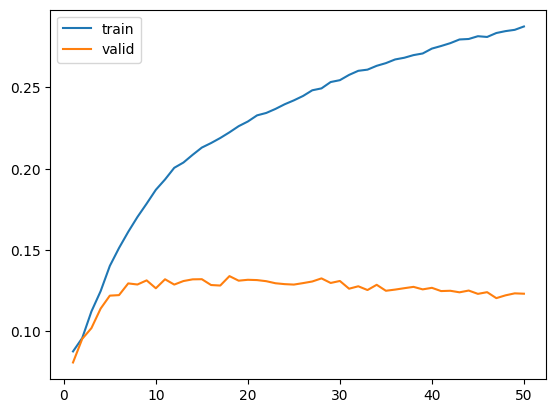

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [61]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [62]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

D:\Users\juanp_schamun\AppData\Local\Temp\ipykernel_10984\182099320.py:24: GradioDeprecationWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 23ms/step
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [63]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [65]:
input_text='Estimador de la'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 27ms/step


'Estimador de la entre para'

### 7 - Conclusiones
El modelo entrenado tuvo un muy mal desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

En este caso se usaron bastantes más datos que en el ejemplo de clase. Lo que solo contribuyó a un tiempo muy alto de entrenamiento.
La performance es igual de mala.

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.